# Stores-Item demand forecasting by XGBoost
## 1. Preparations

Import related libraries, 
Set up global constants and Hyper parameters for XGBoost,
Load train and test datasets.

### 1.1 Import Libraries

In [320]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import copy

### 1.2 Set up global constants and variables

In [321]:
DATASET_PATH = "./kaggle/input/demand-forecasting-kernels-only/"
TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"
TRAIN_FILEPATH = DATASET_PATH + TRAIN_FILENAME
TEST_FILEPATH = DATASET_PATH + TEST_FILENAME

# Attributes related to training/test data
LABEL = "sales"
COLUMN_DATE = "date"
COLUMN_ID = "id"
COLUMN_DATE_YEAR = "year"
# orignial features
FEATURE_STORE = "store"
FEATURE_ITEM = "item"
# created features
FEATURE_DATE_MONTH = "month"
FEATURE_DATE_QUARTER = "quarter"
FEATURE_DATE_DAYOFWEEk = "dayofweek"
FEATURE_DATE_DAYOFYEAR = "dayofyear"

# For lag features
LAGS = [
    7, # 1 week
    30, # 1 month
    90, # 1 quarter, (max-min) of test dates
    180, # a half year
    365, # a complete year
]

# For Rolling Features
MIN_PERIODS = 15 # half of month due to win_type
WINDOWS = [
    90 + MIN_PERIODS, # 1 quarter, (max-min) of test dates + MIN_PERIODS
    180 + MIN_PERIODS, # a half year + MIN_PERIODS
    365 + MIN_PERIODS, # a complete year + MIN_PERIODS
]
WIN_TYPE = "triang"


# featuren name collection
all_feature_names = [
    FEATURE_STORE,
    FEATURE_ITEM,
    FEATURE_DATE_MONTH,
    FEATURE_DATE_QUARTER,
    FEATURE_DATE_DAYOFWEEk,
    FEATURE_DATE_DAYOFYEAR,
]


NDIGITS = 4 # precison of round() method
N_SPLITS = 5 # for Kfold

COLOR_PAL = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
plt.style.use(style="fivethirtyeight")

### 1.3 Set up Hyper parameters

In [322]:
## General Parameters

BOOSTER = "gbtree" # gbtree and dart use tree based; gblinear use linear funcitons
DEVICE = "cuda" # cuda, gpu or cpu
VALIDATE_PARAMETERS = True # perform validation of input parameters to check whether a parameter is used or not.
DISABLE_DEFEAULT_EVAL_METRIC = True # use customized sample instead.


## Parameters for Tree Booster

ETA = 0.3 # default 0,3, learning_rate
GAMMA = 0 # default 0, min_split_loss, The larger the more conservative algorithm is.
MAX_DEPTH = 6 # default 6, 0 indicates no limit on depth.
# defalut 1, In regression task, simply corresponds to minimum number of instances in each node.
# The larger hte more conservative
MIN_CHILD_WEIGHT = 1 
# default 0, positive to help making the update step more conservative.
#it might help in logistic regression when class is extremely imbalanced.
MAX_DELTA_STEP = 0 
SUBSAMPLE = 0.5 # default 1, range(0,1], this prevent overfitting
COLSAMPLE_BYTREE = 0.8 # range(0,1]
LAMBDA = 1 #default 1, alias: reg_lambda, L2 regularization term on weights increase to make more conservative
ALPHA = 0 #defalut 0, L1 regularization term on weights
TREE_METHOD = "hist" # tree method of xgboost: auto=hist, exact, approx, hist

## Learning Task Parameters

OBJECTIVE = "reg:squarederror" # objective of learning task
NUM_BOOST_ROUND = 500 # default 10, equivalent to number of gradient boosted trees.
EARLY_STOPPING_ROUNDS = 50 

## Booster parameters of XGBoost model

xgb_params = {
    'booster': BOOSTER,
    'device': DEVICE,
    'validate_parameters': VALIDATE_PARAMETERS,
    'disable_default_eval_metric': DISABLE_DEFEAULT_EVAL_METRIC,
    'objective': OBJECTIVE,
    'min_child_weight': MIN_CHILD_WEIGHT,
    'max_delta_step': MAX_DELTA_STEP,
    'subsample': SUBSAMPLE,
    'colsample_bytree': COLSAMPLE_BYTREE,
    'lambda': LAMBDA,
    'alpha': ALPHA,
    'tree_method': TREE_METHOD,
}


## Parameters for XGBoost cross validation: xgb.cv()

NFOLD = 5
STRATIFIED = False # perform stratified sampling
SHUFFLE = False
AS_PANDAS = True # Return pd.DataFrame



### 1.4 Load Train and Test datasets

In [323]:
train_df = pd.read_csv(TRAIN_FILEPATH, parse_dates=[COLUMN_DATE], index_col=COLUMN_DATE)
test_df = pd.read_csv(TEST_FILEPATH, parse_dates=[COLUMN_DATE], index_col=COLUMN_DATE)
raw_data_concact_df = pd.concat([train_df, test_df])

## 3. Create XGBoost Model
### 3.1 Feature Engineering

In [325]:
def create_features(raw_df: pd.DataFrame, label:str = None):
    def create_time_features(data_df: pd.DataFrame):
        data_df[COLUMN_DATE_YEAR] = data_df.index.year
        data_df[FEATURE_DATE_MONTH] = data_df.index.month
        data_df[FEATURE_DATE_QUARTER] = data_df.index.quarter
        data_df[FEATURE_DATE_DAYOFYEAR] = data_df.index.dayofyear
        data_df[FEATURE_DATE_DAYOFWEEk] = data_df.index.dayofweek
        
    def create_lag_features(data_df: pd.DataFrame):
        for lag in LAGS:
            feature_name = "sales_lag_" + str(lag)
            all_feature_names.append(feature_name)
            data_df[feature_name] = \
                data_df.groupby(by=[FEATURE_STORE, FEATURE_ITEM])[LABEL].\
                    shift(periods=lag)
                
    def create_rolling_mean_features(data_df: pd.DataFrame):
        for window in WINDOWS:
            feature_mean_name = "sales_rolling_mean_" + str(window)
            feature_std_name = "sale_rolling_std_" + str(window)
            all_feature_names.append(feature_mean_name)
            all_feature_names.append(feature_std_name)
            
            data_df[feature_mean_name] = \
                data_df.groupby(by=[FEATURE_STORE, FEATURE_ITEM])[LABEL].\
                    transform(lambda x: x.rolling(window=window, min_periods = MIN_PERIODS, win_type = "triang").mean())
            data_df[feature_std_name] = \
                data_df.groupby(by=[FEATURE_STORE, FEATURE_ITEM])[LABEL].\
                    transform(lambda x: x.rolling(window=window, min_periods = MIN_PERIODS, win_type = "triang").std())
    
    data_df = copy.deepcopy(raw_df)
    create_time_features(data_df)
    create_lag_features(data_df)
    create_rolling_mean_features(data_df)
    
    
    X_data = data_df.loc[:, all_feature_names]
    
    if label:
        y_data = raw_df[label]
        return data_df, X_data, y_data
    else:
        return data_df, X_data
    
data_df, X_data, y_data = create_features(raw_data_concact_df, label=LABEL)

### 3.2 Define customized metrics

In [328]:
def smape(predt: np.ndarray, dtrain: xgb.DMatrix)->tuple[str, float]:
    y = dtrain.get_label()
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    elements = np.abs(predt-y)/((np.abs(predt)+np.abs(y))*0.5)
    return 'smape', round(np.mean(elements)*100, ndigits=NDIGITS)

## 3.3 Data postprocessing

In [329]:
data_df.sort_index(inplace=True)

train_df = data_df.loc[~data_df.sales.isna()]
X_train = train_df[all_feature_names]
y_train = train_df[LABEL]

test_df = data_df[data_df.sales.isna()]
test_df.reset_index(inplace=True)
test_df.set_index(keys = [COLUMN_ID], inplace=True)
test_df = test_df.sort_index()
X_test = test_df[all_feature_names]

dtrain = xgb.DMatrix(data=X_train, label=y_train)

### 3.3 StratifiedKFold cross validation

In [331]:
eval_historys = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    nfold=NFOLD,
    stratified=STRATIFIED,
    as_pandas=AS_PANDAS,
    shuffle=SHUFFLE,
    custom_metric=smape,
)

eval_historys

,train-smape-mean,train-smape-std,test-smape-mean,test-smape-std
0,35.93572,0.234279,36.38996,3.073931
1,28.70548,0.224108,29.21084,3.139260
2,23.45220,0.190914,28.47512,11.854533
3,20.02762,0.204828,25.86580,13.214402
4,17.65070,0.183755,24.51268,15.020645
...,...,...,...,...
113,12.69118,0.204018,16.63044,8.084455
114,12.68902,0.203789,16.61008,8.045134
115,12.68726,0.205177,16.61312,8.050769
116,12.68588,0.205418,16.44940,7.723818


In [332]:
num_boost_round = eval_historys.shape[0]

In [333]:

kfold = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE)

for i,(train_index,validation_index) in enumerate(kfold.split(X=X_train,y=y_train)):
    dtrain = xgb.DMatrix(data = X_train.iloc[train_index, :], label = y_train.iloc[train_index])
    dval = xgb.DMatrix(data=X_train.iloc[validation_index, :], label = y_train.iloc[validation_index])
    
    evals_result = {}
    watch_list = [
        (dtrain,"dtrain"), 
        (dval, "dval"),
    ]
    
    bst = xgb.train(
        params = xgb_params, 
        dtrain = dtrain, 
        num_boost_round=num_boost_round,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        evals = watch_list,
        evals_result = evals_result,
        custom_metric=smape,
    )

[0]	dtrain-smape:35.47750	dval-smape:42.21850
[1]	dtrain-smape:28.26200	dval-smape:35.12410
[2]	dtrain-smape:23.07350	dval-smape:48.21970
[3]	dtrain-smape:19.62000	dval-smape:47.24580
[4]	dtrain-smape:17.27130	dval-smape:49.34170
[5]	dtrain-smape:15.75530	dval-smape:48.08160
[6]	dtrain-smape:14.80520	dval-smape:47.12520
[7]	dtrain-smape:14.23810	dval-smape:46.38560
[8]	dtrain-smape:13.91460	dval-smape:46.01550
[9]	dtrain-smape:13.70420	dval-smape:45.52490
[10]	dtrain-smape:13.57640	dval-smape:45.18920
[11]	dtrain-smape:13.44600	dval-smape:44.42510
[12]	dtrain-smape:13.36080	dval-smape:44.26480
[13]	dtrain-smape:13.30330	dval-smape:44.16120
[14]	dtrain-smape:13.25670	dval-smape:44.07950
[15]	dtrain-smape:13.21060	dval-smape:43.80320
[16]	dtrain-smape:13.17400	dval-smape:42.94930
[17]	dtrain-smape:13.13470	dval-smape:42.91540
[18]	dtrain-smape:13.10280	dval-smape:42.92610
[19]	dtrain-smape:13.06490	dval-smape:42.54600
[20]	dtrain-smape:13.03260	dval-smape:42.51070
[21]	dtrain-smape:13.00

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

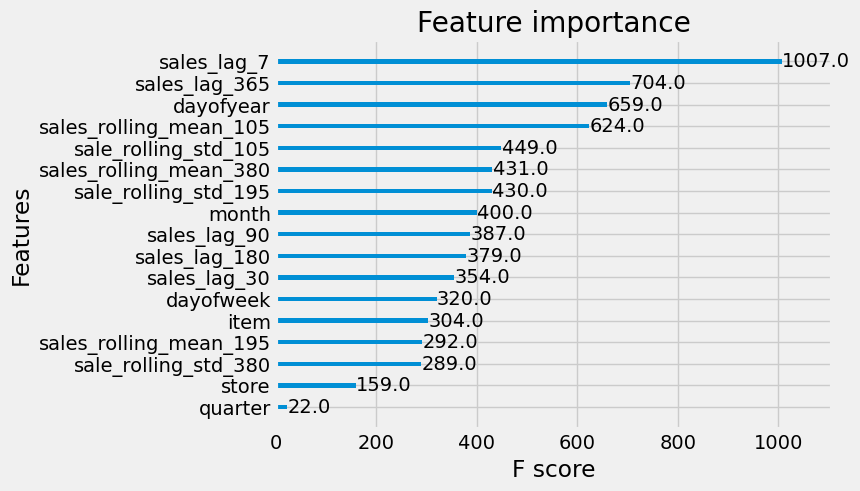

In [334]:
xgb.plot_importance(
    booster=bst
)

In [337]:
dtest = xgb.DMatrix(data=X_test)
predictions = bst.predict(dtest)
test_df[LABEL] = predictions

In [338]:
submission_df = test_df.loc[:,[LABEL]]
submission_df.index = submission_df.index.astype(int)
submission_df.to_csv("submission.csv", index=True)